# The Multi-armed bandit

- 참고: https://jamesrledoux.com/algorithms/bandit-algorithms-epsilon-ucb-exp-python/

A multi-armed bandit algorithm is designed to learn an optimal balance for allocating resources between a fixed number of choices in a situation such as this one, maximizing cumulative rewards over time by learning an efficient explore vs explit policy.

In [3]:
import numpy as np
import pandas as pd

In [102]:
def score(history, df, t, batch_size, recs):
    # replay score. reward if rec matches logged data, ignore otherwise
    actions = df[t:t+batch_size]
    actions = actions[actions['movieId'].isin(recs)]
    actions['scoring_round'] = t
    # add row to history if recs match logging policy
    history = pd.concat([history, actions], axis=0)
    action_liked = actions[['movieId', 'liked']]
    return history, action_liked

# Load Dataset

In [85]:
def preprocess_movie_data_20m(logs, min_number_of_reviews=20, balanced_classes=False):
    print('preparing ratings log')
    # remove ratings of movies with < N ratings. too few ratings will cause the recsys to get stuck in offline evaluation
    count_df = pd.DataFrame(logs.movieId.value_counts())
    print(f"{count_df.max()=} {count_df.min()=}")
    movies_to_keep = count_df.loc[count_df['count']>=min_number_of_reviews].index
    logs = logs[logs['movieId'].isin(movies_to_keep)]

    if balanced_classes is True:
        logs = logs.groupby('movieId')
        logs = logs.apply(lambda x: x.sample(logs.size().min()).reset_index(drop=True))
    # shuffle rows to deibas order of user ids
    logs = logs.sample(frac=1)
    # create a 't' column to represent time steps for the bandit to simulate a live learning scenario
    logs['t'] = np.arange(len(logs))
    logs.index = logs['t']
    logs['liked'] = logs['rating'].apply(lambda x: 1 if x >= 4.5 else 0)
    return logs

In [4]:
ratings = pd.read_csv("../../data/ml-latest-small/ratings.csv")

In [7]:
ratings['liked'] = ratings.rating.map(lambda x: 1 if x>=4.5 else 0)

In [8]:
ratings

,userId,movieId,rating,timestamp,liked
0,1,1,4.0,964982703,0
1,1,3,4.0,964981247,0
2,1,6,4.0,964982224,0
3,1,47,5.0,964983815,1
4,1,50,5.0,964982931,1
...,...,...,...,...,...
100831,610,166534,4.0,1493848402,0
100832,610,168248,5.0,1493850091,1
100833,610,168250,5.0,1494273047,1
100834,610,168252,5.0,1493846352,1


In [88]:
df = preprocess_movie_data_20m(ratings)

preparing ratings log
count_df.max()=count    329
dtype: int64 count_df.min()=count    1
dtype: int64


In [106]:
def epsilon_greedy_policy(df, arms, epsilon=0.15, slate_size=5, batch_size=50):
    '''
    Applies Epsilon Greedy policy to generate movie recommendations.
    Args:
        df: dataframe. Dataset to apply the policy to
        arms: list or array. ID of every eligible arm.
        epsilon: float. represents the % of timesteps where we explore random arms
        slate_size: int. the number of recommendations to make at each step.
        batch_size: int. the number of users to serve these recommendations to before updating the bandit's policy.
    '''
    # draw a 0 or 1 from a binominal distribution, with epsilon% likelihood of drawing a 1
    explore = np.random.binomial(1, epsilon)
    
    # if explore: shuffle movies to choose a random set of recommendations
    if explore == 1 or df.shape[0]==0:
        recs = np.random.choice(arms, size=(slate_size), replace=False)
    # if exploit: sort moveis by "like rate", recommend movies with the best performance so far
    else:
        scores = df[['movieId', 'liked']].groupby('movieId').agg({'liked': ['mean', 'count']})
        scores.columns = ['mean', 'count']
        scores['movieId'] = scores.index
        scores = scores.sort_values('mean', ascending=False)
        recs = scores.loc[scores.index[0:slate_size], 'movieId'].values
    return recs

In [98]:
# Setting Args
batch_size = 50 
verbose = True
epsilon = 0.15
slate_size = 5
batch_size = 50

In [90]:
# initialize empty history
# (offline eval means you can only add to histroy when rec mathces historic data)
history = pd.DataFrame(data=None, columns=df.columns)
history = history.astype({'movieId': 'int32', 'liked': 'float'})

In [107]:
# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation

rewards = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size):
    t = t * batch_size
    if t % 100000 == 0:
        if verbose:
            print(t)
    # choose which arm to pull
    # apply epsilon greedy policy to the historic dataset (all arm-pulls prior to the current step that passed the replay-filter)
    recs = epsilon_greedy_policy(df=history.loc[history.t<=t,], arms=df.movieId.unique(), epsilon=epsilon, slate_size=slate_size, batch_size=batch_size)
    history, action_score = score(history, df, t, batch_size, recs)
    if action_score is not None:
        action_score = action_score.liked.tolist()
        rewards.extend(action_score)

0


In [112]:
import matplotlib.pyplot as plt

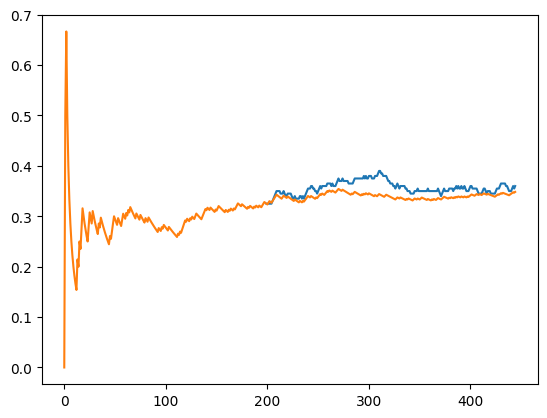

In [116]:
cumulative_avg = np.cumsum(rewards) / np.linspace(1, len(rewards), len(rewards))
plt.plot(pd.Series(rewards).rolling(200).mean(), label='epsilon')
plt.plot(cumulative_avg, label='epsilon')